Studying the effect of variability on BP
# Loading the libraries

In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.datasets import fetch_openml
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from numba import njit, cuda

# Preparing the dataset

In [2]:
#fetch the mnist dataset
x, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
#x, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
print(x.shape,y.shape)

(70000, 784) (70000,)


In [3]:
#x_n = x.to_numpy()
x_n = x
#y_n = y.to_numpy()
y_n = y

In [4]:
y_n = y_n.astype('int') #convert output to integers 0-9
x_norm = x_n/255.0 #normalise input data
x_train, x_val, y_train, y_val = train_test_split(x_norm, y_n, test_size=0.1, random_state=42) #split the data into train and validation
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

x_train = x_train.T #take the transpose of the training data m*784 -> 784*m
x_val = x_val.T #take the transpose of the test data m*784 -> 784*m
print(x_train.shape, x_val.shape)

(63000, 784) (7000, 784) (63000,) (7000,)
(784, 63000) (784, 7000)


In [5]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Training software BP with new subsampled version of MNIST

In [6]:
def params_init(newShape, midLayerSize, seed=2):

  np.random.seed(seed)
  W1 = np.random.rand(midLayerSize,newShape) - 0.5
  b1 = np.random.rand(midLayerSize,1) - 0.5
  W2 = np.random.rand(10,midLayerSize) - 0.5 
  b2 = np.random.rand(10,1) - 0.5 
  print("Params Initialised")

  return (W1, b1, W2, b2)

In [7]:

def predictions(A):
  #argmax returns the index of maximum value, we will feed the sigmoid output to this function 
  return np.argmax(A,0)


def accuracy(A,Y):
  #this will compare the predicted output to the ground truth
  return np.sum(A == Y)/(Y.shape[0])*100

In [8]:
def relu(x):
   return np.maximum(x,0)


def softmax(Z):
  return np.exp(Z) / np.sum(np.exp(Z),0)
  #Z = Z-np.max(Z, axis=0)
  #return np.exp(Z) / np.sum(np.exp(Z),0)


def relu_d(x):
  return x>0

def one_hot_encoding(y):
  shape = (y.shape[0], 10)
  one_hot = np.zeros(shape)
  rows = np.arange(y.size)
  one_hot[rows, y] = 1
  return one_hot.T

def crossEntropy(y,y_pre):
  loss=-np.sum(np.multiply(y, np.log(y_pre + 10e-16)), axis = 0)
  return loss

In [9]:
def forward(x_train, W1, b1, W2, b2):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2
  A2 = softmax(Z2)
  

  return Z1, A1, Z2, A2

In [10]:
def param_update(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):

  #updates the parameters based on backpropogation

  W1 = W1 - lr*dW1
  b1 = b1 - lr*(db1.reshape(b1.shape))
  W2 = W2 - lr*dW2
  b2 = b2 - lr*(db2.reshape(b2.shape))


  return W1, b1, W2, b2

In [11]:
def backprop(Z1, A1, Z2, A2, W1, W2, X, y):
  m = y.shape[0] #m is the number of training examples
  Y = one_hot_encoding(y)

  dZ2 = (A2 - Y)
  
  dW2 = 1/m*np.matmul(dZ2,A1.T)

  db2 = 1/m*np.sum(dZ2, axis=1)

  dZ1 = np.matmul(W2.T, dZ2)*relu_d(Z1) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW1 = 1/m*np.matmul(dZ1,X.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis=1) #db1 is 50*1


  return dW1, db1, dW2, db2

In [12]:
def batch_grad_descent(X,Y,batchsize,iter, lr, midLayerSize, seed = None, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}
  newShape = X[:, 0].shape[0]
  W1, b1, W2, b2 = params_init(newShape=newShape, midLayerSize = midLayerSize, seed = seed)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(63000//batchsize): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*batchsize: (j+1)*batchsize].T,Y[j*batchsize: (j+1)*batchsize]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes
      #X1, Y1 = X, Y

      Z1, A1, Z2, A2 = forward(X1, W1, b1, W2, b2) 

      dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)


      W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _,  A2_train = forward(X, W1, b1, W2, b2)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,   A2_val = forward(x_val, W1, b1, W2, b2)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score} Val loss: {np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')
      # plt.figure()
      # plt.hist(W1.flatten())

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [126]:
_, _, _, _, train_accBP, val_accBP, train_loss, val_loss, sum_weights = batch_grad_descent(x_train,y_train,batchsize = 100,iter=100, lr=0.1,midLayerSize = 10, seed = 2,print_op=1);

Params Initialised
Iteration: 1
Train accuracy: 75.01746031746032
Val accuracy: 74.35714285714286 Val loss: 4924.942876762841
Iteration: 2
Train accuracy: 78.63968253968254
Val accuracy: 78.2 Val loss: 4264.667712969776
Iteration: 3
Train accuracy: 80.20793650793651
Val accuracy: 79.5 Val loss: 3980.600674369738
Iteration: 4
Train accuracy: 81.1031746031746
Val accuracy: 80.68571428571428 Val loss: 3816.2054320040274
Iteration: 5
Train accuracy: 81.81428571428572
Val accuracy: 81.25714285714287 Val loss: 3685.011076244544
Iteration: 6
Train accuracy: 82.4063492063492
Val accuracy: 81.87142857142857 Val loss: 3574.3633303950473
Iteration: 7
Train accuracy: 82.86349206349206
Val accuracy: 82.32857142857142 Val loss: 3485.447623525683
Iteration: 8
Train accuracy: 83.21587301587302
Val accuracy: 82.58571428571429 Val loss: 3408.9371287544027
Iteration: 9
Train accuracy: 83.54603174603174
Val accuracy: 82.91428571428571 Val loss: 3351.440442210497
Iteration: 10
Train accuracy: 83.8365079365

### Generic functions related to variability

In [13]:
#helps in rounding to the nearest integer multiples of the chosen 'step' value!
#add clipping here
# def roundArbitrary(weightArray, step):
#   weightArrayDiv = weightArray / step
#   weightArrayDiv = np.round(weightArrayDiv)
#   return weightArrayDiv*step
def roundArbitrary(weightArray, step, wRange):#updates function with clipping
    #wRange is added for the clipping component 

    weightArrayDiv = np.clip(weightArray, a_min = -wRange, a_max = wRange)
    weightArrayDiv = weightArrayDiv / step
    weightArrayDiv = np.round(weightArrayDiv)
    return weightArrayDiv*step

In [14]:
def initMosParam(shape, mu, sigma, vDD, precision, k=100):
    #modelling both Ion and Ioff  = I0*exp(Vgs-Vth/(eta*kB*T)),
    dim1, dim2 = shape
    sizeI = (dim1, dim2, precision)
    I0On = 1e+06
    I0Off = I0On/k
    #eta = 
    #kB = 1.3806452e10-23
    #T = 300
    VT = 0.026*1.5#should be eqaul to eta x kB x T

    #Vth = getVth(mu, sigma, sizeI)#get the array of Vth values 
    Vth = np.random.normal(loc=mu, scale=sigma, size = sizeI)
    Vth[Vth<=0] = 10e-10

    #iOn = ((vDD - Vth)**2)*I0On#scaling the current according to Ioff values arbitraryfor now!!
    iOn = I0On * np.exp((0 - Vth)/(VT))
    #iOn = I0On * np.ones_like(Vth)



    #iOnNominal = 1e-06*(vDD**2 - (2*vDD*mu) + (sigma**2  + mu**2))
    iOnNominal = np.sum(iOn)/(dim1*dim2*precision)
    #Vth = np.random.normal(loc=mu, scale=sigma, size = sizeI)
    #iOff = np.random.uniform(low=0, high=1e-8, size = sizeI)#no negative value
    iOff = I0Off * np.exp((0 - Vth)/(VT))
    #iOff = I0Off * np.ones_like(Vth)
    return (iOn, iOnNominal, iOff)

In [15]:
def weightTransformWithVariability(weightArray, currents, precision, step, discreteSteps, wRange):
  dim1, dim2 = weightArray.shape
  sizeI = (dim1, dim2, precision)

  #clippedWeightIndexArray = np.digitize(np.abs(weightArray), discreteSteps) #finds the index value of the weights
  #updating the above to the actual round function.
  clippedWeightIndexArray = (roundArbitrary(weightArray, step, wRange)/step).astype(np.int64)
  clippedWeightIndexArray = np.abs(clippedWeightIndexArray)

  #vDD = 5
  #mu = 0.7#mean of the distribution
  #sigma = 0.00001
  #! work with sigma/mu
  
  iOn, iOnNominal, iOff = currents

  
  analogWeightArray = np.zeros_like(weightArray, dtype=float)

  for bitLevel in range(precision):
    analogWeightArray +=  np.where(np.bitwise_and(clippedWeightIndexArray, 2**bitLevel)>=1, iOn[:, :, bitLevel], iOff[:, :, bitLevel]) * (2**bitLevel)

  
  analogWeightArray  = np.multiply(np.sign(weightArray), analogWeightArray)

  weightWithVariability = (analogWeightArray/iOnNominal)*step
  return weightWithVariability

In [16]:
def WPwithVarUp(W1, b1, W2, b2, pert, lossBeforePert, X, y, precision, step, discreteSteps, wRange,  W1Var, b1Var, W2Var, b2Var, W1Currents, b1Currents, W2Currents, b2Currents):
    #assert pert==step #to get increments of '1' in the bit pattern of the weight array
    #!here we chnage perturb only one value
    m = y.shape[0] #m is the number of training examples
    Y = one_hot_encoding(y)
    dW1 = np.zeros_like(W1)
    lossAfterPertW1 = np.zeros_like(W1)
    
    W1pert = W1.copy()
    W1pert += pert
    W1pertArrTr = weightTransformWithVariability(W1pert, W1Currents, precision, step, discreteSteps, wRange)
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W1pertLoop = W1Var.copy()
            W1pertLoop[i, j] = W1pertArrTr[i, j]
            #print(W1pertLoop - W1Var)
            #plt.figure()
            #plt.plot(W1Var.flatten(), W1pertLoop.flatten(), '.')
            #plt.title("W1 comp")
            #do the transform only on that perturbed weight and place it in the correct place
            #W1pertArrTr = weightTransformWithVariability(W1pert, W1Currents, precision, step, discreteSteps, wRange)
            _, _, _, A2pert = forward(X, W1pertLoop, b1Var, W2Var, b2Var)
            #print(A2pert)
            lossAfterPertW1[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
            dW1[i, j] = 1/m * (np.sum(crossEntropy(one_hot_encoding(y), A2pert))-lossBeforePert)/(W1pertArrTr[i,j] - W1Var[i,j]+ 10e-16)
    #dW1 = 1/m * (lossAfterPertW1-lossBeforePert)/pert
    #print(lossAfterPertW1-lossBeforePert)


    db1 = np.zeros_like(b1)
    lossAfterPertb1 = np.zeros_like(b1)

    b1pert = b1.copy()
    b1pert +=pert
    b1pertArrTr = weightTransformWithVariability(b1pert, b1Currents, precision, step, discreteSteps, wRange)

    for i in range(b1.shape[0]):
        b1pertLoop = b1Var.copy()
        b1pertLoop[i]=b1pertArrTr[i]
        #b1pertArrTr = weightTransformWithVariability(b1pert, b1Currents, precision, step, discreteSteps, wRange)
        _, _, _, A2pert = forward(X, W1Var, b1pertLoop, W2Var, b2Var)
        lossAfterPertb1[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
        db1[i] = 1/m * (np.sum(crossEntropy(one_hot_encoding(y), A2pert))-lossBeforePert)/(b1pertArrTr[i] - b1Var[i] + 10e-16)
    #db1 = 1/m * (lossAfterPertb1-lossBeforePert)/pert

    
    dW2 = np.zeros_like(W2)
    lossAfterPertW2 = np.zeros_like(W2)

    W2pert = W2.copy()
    W2pert += pert
    W2pertArrTr = weightTransformWithVariability(W2pert, W2Currents, precision, step, discreteSteps, wRange)

    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W2pertLoop = W2Var.copy()
            W2pertLoop[i, j] = W2pertArrTr[i, j]
            #W2pertArrTr = weightTransformWithVariability(W2pert, W2Currents, precision, step, discreteSteps, wRange)
            _, _, _, A2pert = forward(X, W1Var, b1Var, W2pertLoop, b2Var)
            lossAfterPertW2[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
            dW2[i, j] = 1/m * (np.sum(crossEntropy(one_hot_encoding(y), A2pert))-lossBeforePert)/(W2pertArrTr[i,j] - W2Var[i,j]+ 10e-16)
    #dW2 = 1/m * (lossAfterPertW2-lossBeforePert)/pert
    #print(lossAfterPertW2)


    db2 = np.zeros_like(b2)
    lossAfterPertb2 = np.zeros_like(b2)

    b2pert = b2.copy()
    b2pert += pert
    b2pertArrTr = weightTransformWithVariability(b2pert, b2Currents, precision, step, discreteSteps, wRange)


    for i in range(b2.shape[0]):
        b2pertLoop = b2Var.copy()
        b2pertLoop[i] = b2pertArrTr[i]
        #b2pertArrTr = weightTransformWithVariability(b2pert, b2Currents, precision, step, discreteSteps, wRange)
        _, _, _, A2pert = forward(X, W1Var, b1Var, W2Var, b2pertLoop)
        lossAfterPertb2[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
        db2[i] = 1/m * (np.sum(crossEntropy(one_hot_encoding(y), A2pert))-lossBeforePert)/(b2pertArrTr[i] - b2Var[i]+ 10e-16)

    #db2 = 1/m * (lossAfterPertb2-lossBeforePert)/pert

    return dW1, db1, dW2, db2
            

In [17]:
def batch_grad_descentBPVarUpdateComp(X,Y, batchsize,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,seed = None, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []


  newShape = X[:, 0].shape[0]
  W1, b1, W2, b2 = params_init(newShape=newShape, midLayerSize = midLayerSize, seed = seed)
  W1 = roundArbitrary(W1, step, wRange)#weights have to maintained as their digitized versions
  b1 = roundArbitrary(b1, step, wRange)
  W2 = roundArbitrary(W2, step, wRange)
  b2 = roundArbitrary(b2, step, wRange)

  #blind updates
  W1bu = W1.copy()
  b1bu = b1.copy()
  W2bu = W2.copy()
  b2bu = b2.copy()

  #variability aware updates
  W1va = W1.copy()
  b1va = b1.copy()
  W2va = W2.copy()
  b2va = b2.copy()

  disArr = np.array([(-1)*i for i in discreteSteps[::-1]] + discreteSteps)
  
  W1Currents = initMosParam((midLayerSize, newShape), mu, sigma, vDD, precision, k =onoff)#k = Ion/Ioff
  b1Currents = initMosParam((midLayerSize, 1), mu, sigma, vDD, precision, k =onoff)
  W2Currents = initMosParam((10, midLayerSize) ,mu, sigma, vDD, precision, k =onoff)
  b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision, k =onoff)




  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(63000//batchsize): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batchsize = 630
      X1, Y1 = shuffle(X[:, j*batchsize: (j+1)*batchsize].T,Y[j*batchsize: (j+1)*batchsize]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes
      #X1, Y1 = X, Y


      #variability aware updates
    
      


      #blind updates
      W1varoc = weightTransformWithVariability(W1bu, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1bu, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2bu, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2bu, b2Currents, precision, step, discreteSteps, wRange)

      Z1, A1, Z2, A2 = forward(X1, W1varoc, b1varoc, W2varoc, b2varoc) 

      dW1bu, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1varoc, W2varoc, X1, Y1)

      W1bu, b1bu, W2bu, b2bu = param_update(W1varoc, b1varoc, W2varoc,b2varoc, dW1bu, db1, dW2, db2, lr = lr)

      W1bu = roundArbitrary(W1bu, step, wRange)#weights have to maintained as their digitized versions
      b1bu = roundArbitrary(b1bu, step, wRange)
      W2bu = roundArbitrary(W2bu, step, wRange)
      b2bu = roundArbitrary(b2bu, step, wRange)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      W1varoc = weightTransformWithVariability(W1bu, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1bu, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2bu, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2bu, b2Currents, precision, step, discreteSteps, wRange)
      _, _, _,  A2_train = forward(X, W1varoc, b1varoc, W2varoc, b2varoc)
      _, _, _,   A2_val = forward(x_val, W1varoc, b1varoc, W2varoc, b2varoc)
      buAccTrainAcc = accuracy(predictions(A2_train), Y)
      buTrainLoss = np.sum(crossEntropy(one_hot_encoding(Y), A2_train))
      buAccValAcc = accuracy(predictions(A2_val), y_val)
      buValLoss = np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))


  
      train_acc.append(buAccTrainAcc)
      print(f'Training :: Blind : {buAccTrainAcc}')


      val_acc.append(buAccValAcc)
      print(f'Validation  :: Blind : {buAccValAcc} :: Blind Loss : {buValLoss}')

      # plt.figure()
      # plt.plot(dW1bu.flatten(), dW1bu.flatten(), alpha = 0.5)
      # plt.plot(dW1bu.flatten(), actualW1vaUpdate.flatten(), '.')
      # plt.xlabel("Blind weights")
      # plt.ylabel("VA weights")

    

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [18]:
def batch_grad_descentBPQuant(X,Y,batchsize,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,seed = None, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []


  newShape = X[:, 0].shape[0]
  W1, b1, W2, b2 = params_init(newShape=newShape, midLayerSize = midLayerSize, seed = seed)
  W1 = roundArbitrary(W1, step, wRange)#weights have to maintained as their digitized versions
  b1 = roundArbitrary(b1, step, wRange)
  W2 = roundArbitrary(W2, step, wRange)
  b2 = roundArbitrary(b2, step, wRange)


  disArr = np.array([(-1)*i for i in discreteSteps[::-1]] + discreteSteps)
  
  W1Currents = initMosParam((midLayerSize, newShape), mu, sigma, vDD, precision, k =onoff)#k = Ion/Ioff
  b1Currents = initMosParam((midLayerSize, 1), mu, sigma, vDD, precision, k =onoff)
  W2Currents = initMosParam((10, midLayerSize) ,mu, sigma, vDD, precision, k =onoff)
  b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision, k =onoff)




  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(63000//batchsize): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*batchsize: (j+1)*batchsize].T,Y[j*batchsize: (j+1)*batchsize]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes
      #X1, Y1 = X, Y


      #variability aware updates
    
      


      #blind updates
      # W1varoc = weightTransformWithVariability(W1bu, W1Currents, precision, step, discreteSteps, wRange)
      # b1varoc = weightTransformWithVariability(b1bu, b1Currents, precision, step, discreteSteps, wRange)
      # W2varoc = weightTransformWithVariability(W2bu, W2Currents, precision, step, discreteSteps, wRange)
      # b2varoc = weightTransformWithVariability(b2bu, b2Currents, precision, step, discreteSteps, wRange)

      Z1, A1, Z2, A2 = forward(X1, W1, b1, W2, b2) 

      dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)

      W1, b1, W2, b2 = param_update(W1, b1, W2,b2, dW1, db1, dW2, db2, lr = lr)

      W1 = roundArbitrary(W1, step, wRange)#weights have to maintained as their digitized versions
      b1 = roundArbitrary(b1, step, wRange)
      W2 = roundArbitrary(W2, step, wRange)
      b2 = roundArbitrary(b2, step, wRange)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      _, _, _,  A2_train = forward(X, W1, b1, W2, b2)
      _, _, _,   A2_val = forward(x_val, W1, b1, W2, b2)
      buAccTrainAcc = accuracy(predictions(A2_train), Y)
      buTrainLoss = np.sum(crossEntropy(one_hot_encoding(Y), A2_train))
      buAccValAcc = accuracy(predictions(A2_val), y_val)
      buValLoss = np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))


  
      train_acc.append(buAccTrainAcc)
      print(f'Training :: Blind : {buAccTrainAcc}')


      val_acc.append(buAccValAcc)
      print(f'Validation  :: Blind : {buAccValAcc} :: Blind Loss : {buValLoss}')

      # plt.figure()
      # plt.plot(dW1bu.flatten(), dW1bu.flatten(), alpha = 0.5)
      # plt.plot(dW1bu.flatten(), actualW1vaUpdate.flatten(), '.')
      # plt.xlabel("Blind weights")
      # plt.ylabel("VA weights")

    

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [19]:
mu = 0.7
sigma = 0.0000000001
onoff = 10000000000
vDD = 5
precision = 8#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
iter = 100
midLayerSize = 50 #10
lr = 0.2 #0.1
batchsize = 100

In [137]:
W1, b1, W2, b2, train_acc_quant, val_acc_quant, train_loss, val_loss, sum_weights = batch_grad_descentBPQuant(x_train,y_train,batchsize,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,seed = 2,print_op=1)

Params Initialised
Iteration: 1
Training :: Blind : 89.1984126984127
Validation  :: Blind : 88.8 :: Blind Loss : 2654.5305368893105
Iteration: 2
Training :: Blind : 91.00476190476189
Validation  :: Blind : 90.45714285714286 :: Blind Loss : 2253.130603990226
Iteration: 3
Training :: Blind : 91.93333333333334
Validation  :: Blind : 91.5 :: Blind Loss : 2035.0083687003885
Iteration: 4
Training :: Blind : 92.58730158730158
Validation  :: Blind : 92.08571428571429 :: Blind Loss : 1891.8776549767463
Iteration: 5
Training :: Blind : 93.01428571428572
Validation  :: Blind : 92.38571428571429 :: Blind Loss : 1803.7446971542704
Iteration: 6
Training :: Blind : 93.36666666666666
Validation  :: Blind : 92.74285714285713 :: Blind Loss : 1734.9954470623616
Iteration: 7
Training :: Blind : 93.52222222222221
Validation  :: Blind : 92.80000000000001 :: Blind Loss : 1706.3123239999768
Iteration: 8
Training :: Blind : 93.7063492063492
Validation  :: Blind : 92.91428571428571 :: Blind Loss : 1672.79337967

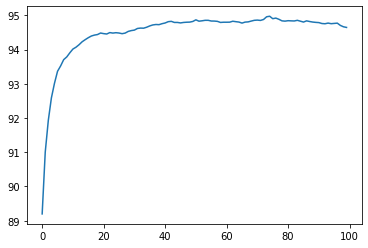

In [138]:
plt.plot(train_acc_quant)

In [96]:
####DO NOT CHANGE THE #PRECISION# PARAMETER
mu = 0.7
sigma = 0.0000000001
onoff = 10000000000
vDD = 5
precision = 8#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
iter = 100
midLayerSize = 50 #10
lr = 0.2 #0.1

In [139]:
#finding qauantization accuacy
W1, b1, W2, b2, train_acc_var, val_acc_var, train_loss, val_loss, sum_weights = batch_grad_descentBPVarUpdateComp(x_train,y_train,batchsize, iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,seed = 2,print_op=1)

Params Initialised
Iteration: 1
Training :: Blind : 89.26031746031747
Validation  :: Blind : 88.78571428571429 :: Blind Loss : 2654.0046723023797
Iteration: 2
Training :: Blind : 90.98095238095239
Validation  :: Blind : 90.5 :: Blind Loss : 2256.4394801469357
Iteration: 3
Training :: Blind : 91.96349206349205
Validation  :: Blind : 91.38571428571429 :: Blind Loss : 2034.299344445678
Iteration: 4
Training :: Blind : 92.58412698412698
Validation  :: Blind : 91.91428571428571 :: Blind Loss : 1897.8855659400178
Iteration: 5
Training :: Blind : 93.02063492063493
Validation  :: Blind : 92.4 :: Blind Loss : 1804.8971686028008
Iteration: 6
Training :: Blind : 93.33492063492064
Validation  :: Blind : 92.52857142857142 :: Blind Loss : 1743.9181184647941
Iteration: 7
Training :: Blind : 93.53333333333333
Validation  :: Blind : 92.77142857142857 :: Blind Loss : 1699.8466912947194
Iteration: 8
Training :: Blind : 93.71904761904763
Validation  :: Blind : 92.81428571428572 :: Blind Loss : 1662.520558

Text(0, 0.5, 'Accuracy')

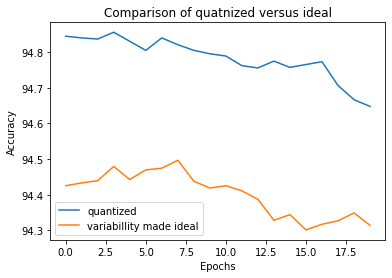

In [141]:
plt.figure()
plt.plot(train_acc_quant, label = "quantized")
plt.plot(train_acc_var, label = "variabillity made ideal")
plt.legend()
plt.title("Comparison of quatnized versus ideal")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [20]:
def batch_grad_descentBPComp(X,Y, batchsize,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,seed = None, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []


  newShape = X[:, 0].shape[0]
  W1, b1, W2, b2 = params_init(newShape=newShape, midLayerSize = midLayerSize, seed = seed)
  W1 = roundArbitrary(W1, step, wRange)#weights have to maintained as their digitized versions
  b1 = roundArbitrary(b1, step, wRange)
  W2 = roundArbitrary(W2, step, wRange)
  b2 = roundArbitrary(b2, step, wRange)

  
  #va = with variability
  W1bu = W1.copy()
  b1bu = b1.copy()
  W2bu = W2.copy()
  b2bu = b2.copy()

  #bu = software quantization i.e. only quantization not variability
  W1va = W1.copy()
  b1va = b1.copy()
  W2va = W2.copy()
  b2va = b2.copy()

  disArr = np.array([(-1)*i for i in discreteSteps[::-1]] + discreteSteps)
  
  W1Currents = initMosParam((midLayerSize, newShape), mu, sigma, vDD, precision, k =onoff)#k = Ion/Ioff
  b1Currents = initMosParam((midLayerSize, 1), mu, sigma, vDD, precision, k =onoff)
  W2Currents = initMosParam((10, midLayerSize) ,mu, sigma, vDD, precision, k =onoff)
  b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision, k =onoff)




  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(63000//batchsize): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batchsize = 630
      X1, Y1 = shuffle(X[:, j*batchsize: (j+1)*batchsize].T,Y[j*batchsize: (j+1)*batchsize]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes
      #X1, Y1 = X, Y


      #variability aware updates
    
      


      #blind updates
      W1varoc = weightTransformWithVariability(W1bu, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1bu, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2bu, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2bu, b2Currents, precision, step, discreteSteps, wRange)

      Z1, A1, Z2, A2 = forward(X1, W1varoc, b1varoc, W2varoc, b2varoc) 

      dW1bu, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1varoc, W2varoc, X1, Y1)

      W1bu, b1bu, W2bu, b2bu = param_update(W1varoc, b1varoc, W2varoc,b2varoc, dW1bu, db1, dW2, db2, lr = lr)

      W1bu = roundArbitrary(W1bu, step, wRange)#weights have to maintained as their digitized versions
      b1bu = roundArbitrary(b1bu, step, wRange)
      W2bu = roundArbitrary(W2bu, step, wRange)
      b2bu = roundArbitrary(b2bu, step, wRange)



      #pure quantization
      Z1, A1, Z2, A2 = forward(X1, W1va, b1va, W2va, b2va) 

      dW1va, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1va, W2va, X1, Y1)

      W1va, b1va, W2va, b2va = param_update(W1va, b1va, W2va,b2va, dW1va, db1, dW2, db2, lr = lr)

      W1va = roundArbitrary(W1va, step, wRange)#weights have to maintained as their digitized versions
      b1va = roundArbitrary(b1va, step, wRange)
      W2va = roundArbitrary(W2va, step, wRange)
      b2va = roundArbitrary(b2va, step, wRange)

      plt.figure()
      plt.plot(dW1va.flatten(), dW1bu.flatten(), 'b.', label = "comparison of weigts")
      plt.plot(dW1va.flatten(), dW1va.flatten(), 'r.', label = "one-one")
      plt.figure()
      plt.plot(W1va.flatten(), W1bu.flatten())

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      W1varoc = weightTransformWithVariability(W1bu, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1bu, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2bu, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2bu, b2Currents, precision, step, discreteSteps, wRange)
      _, _, _,  A2_train = forward(X, W1varoc, b1varoc, W2varoc, b2varoc)
      _, _, _,   A2_val = forward(x_val, W1varoc, b1varoc, W2varoc, b2varoc)
      buAccTrainAcc = accuracy(predictions(A2_train), Y)
      buTrainLoss = np.sum(crossEntropy(one_hot_encoding(Y), A2_train))
      buAccValAcc = accuracy(predictions(A2_val), y_val)
      buValLoss = np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))


  
      train_acc.append(buAccTrainAcc)
      print(f'Training :: Blind : {buAccTrainAcc}')


      val_acc.append(buAccValAcc)
      print(f'Validation  :: Blind : {buAccValAcc} :: Blind Loss : {buValLoss}')

      # plt.figure()
      # plt.plot(dW1bu.flatten(), dW1bu.flatten(), alpha = 0.5)
      # plt.plot(dW1bu.flatten(), actualW1vaUpdate.flatten(), '.')
      # plt.xlabel("Blind weights")
      # plt.ylabel("VA weights")

    

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


Params Initialised


C:\Users\HP\AppData\Local\Temp\ipykernel_16780\3355174751.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


KeyboardInterrupt: 

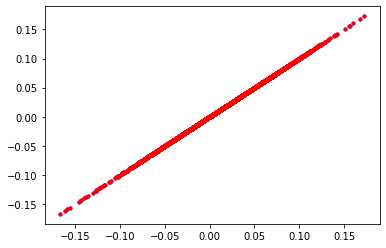

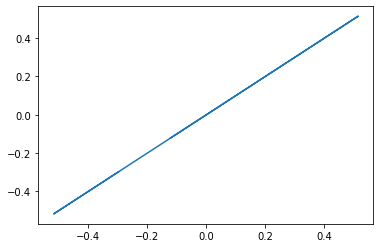

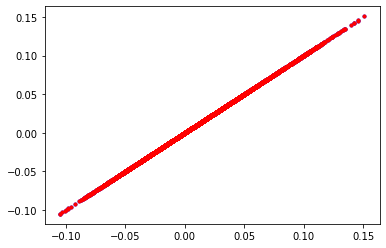

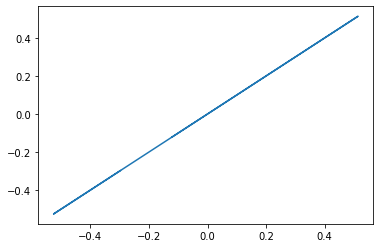

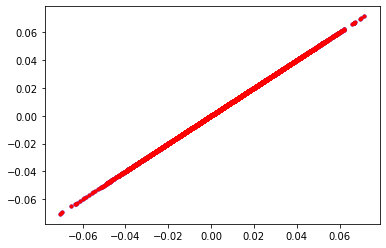

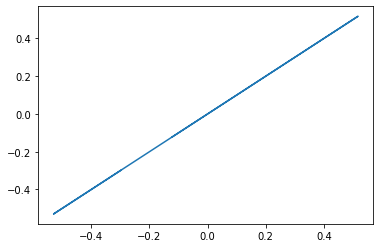

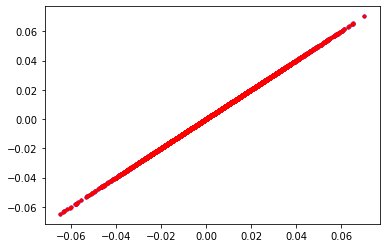

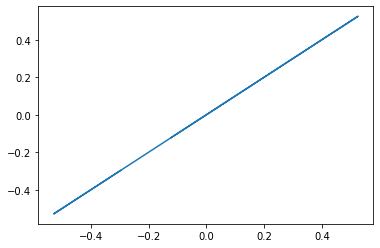

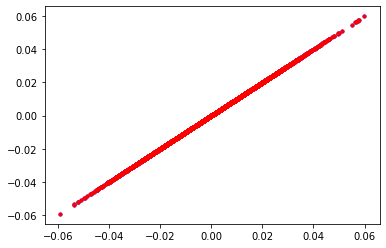

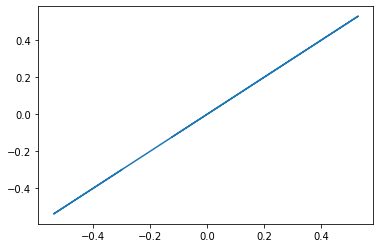

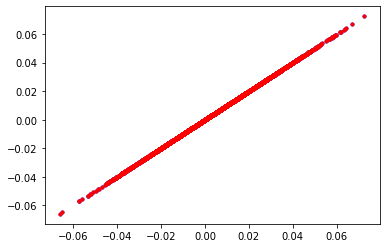

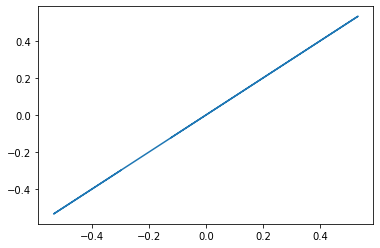

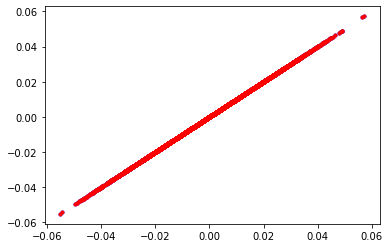

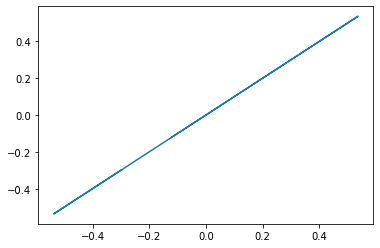

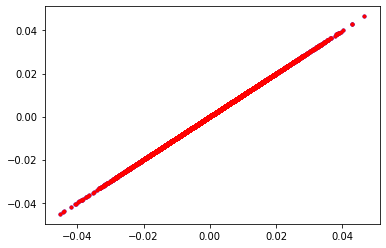

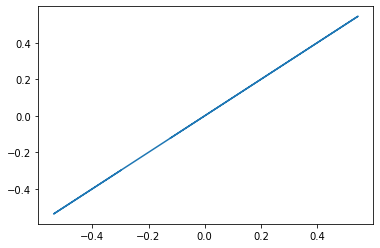

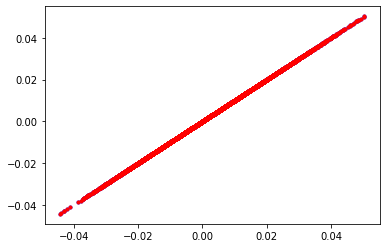

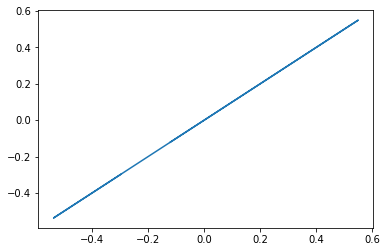

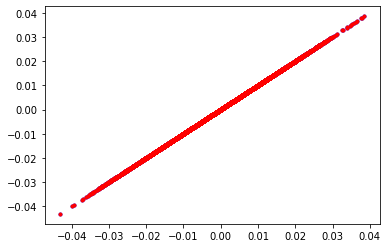

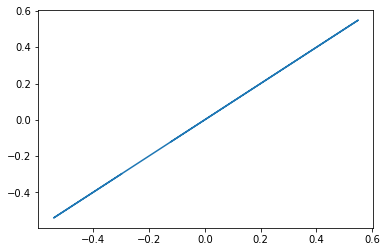

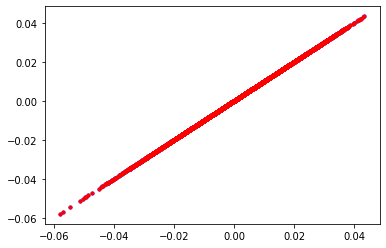

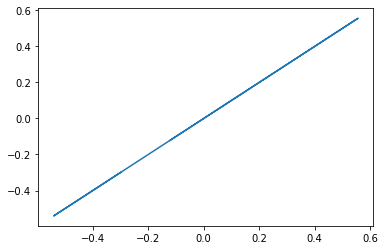

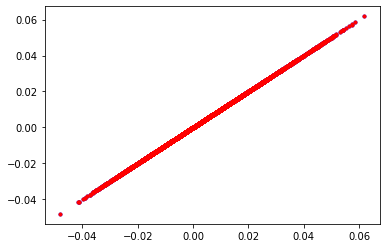

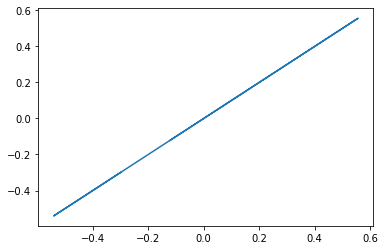

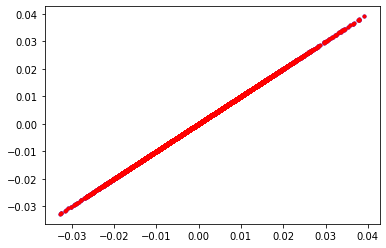

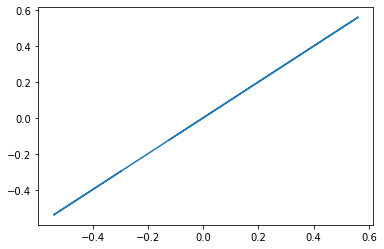

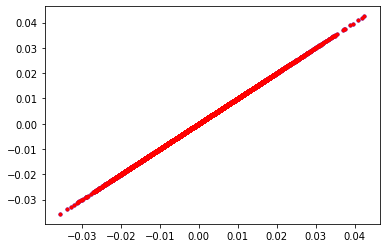

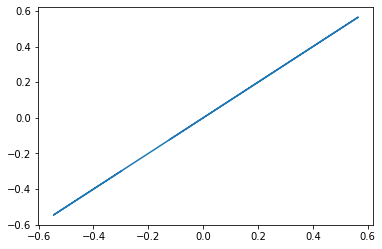

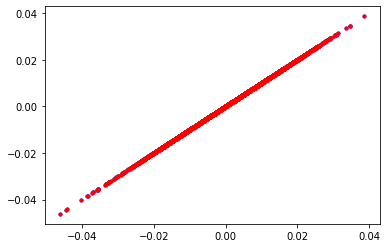

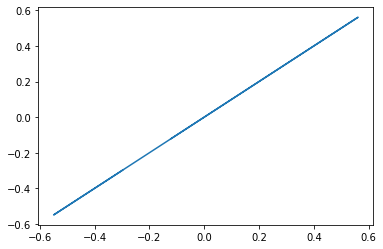

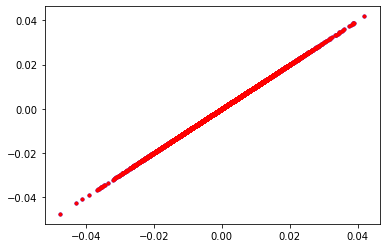

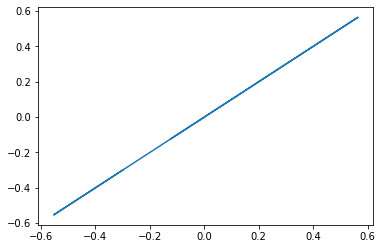

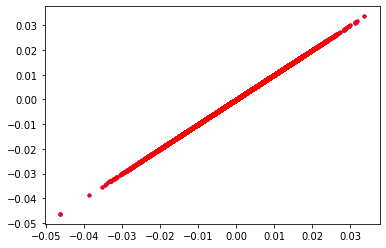

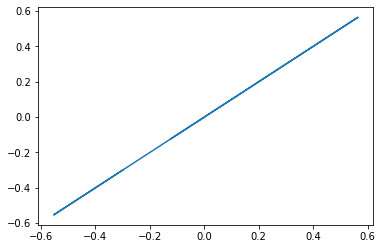

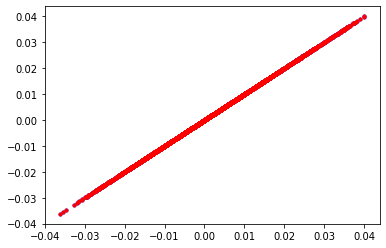

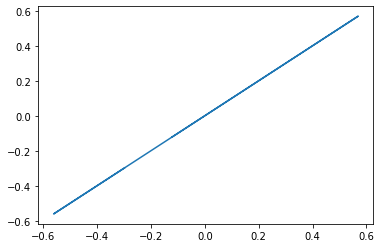

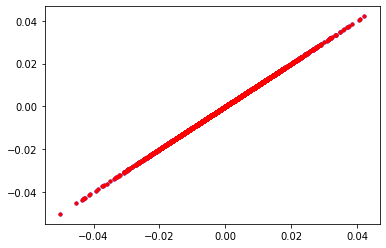

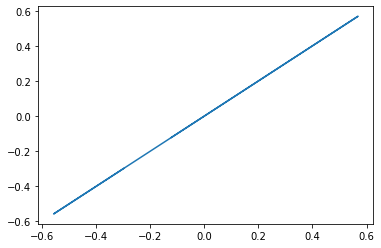

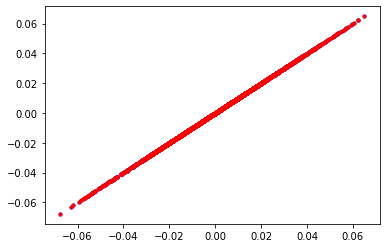

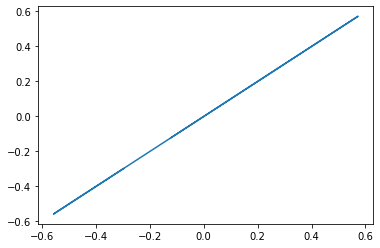

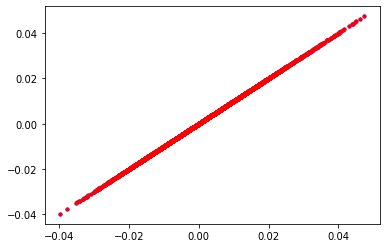

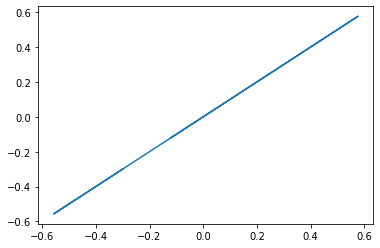

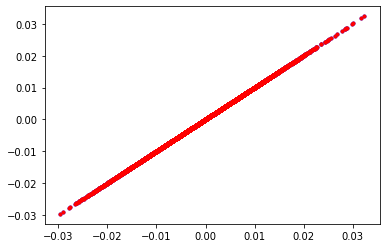

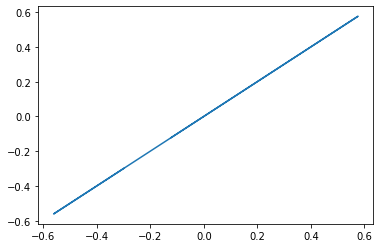

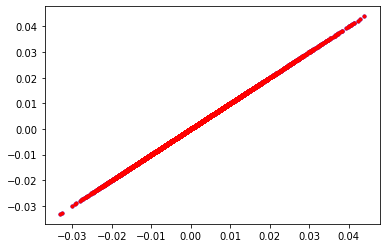

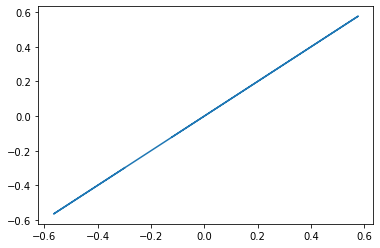

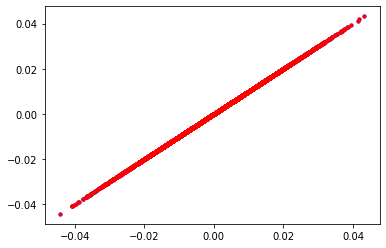

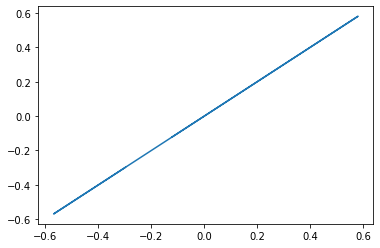

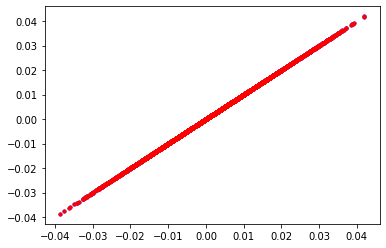

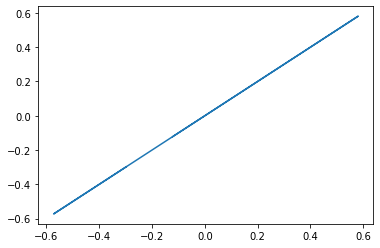

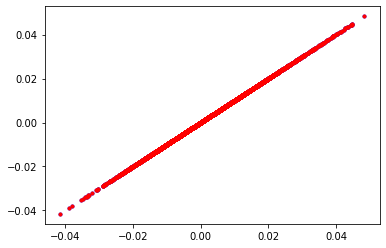

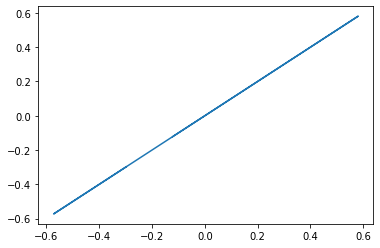

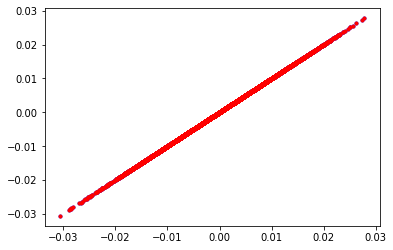

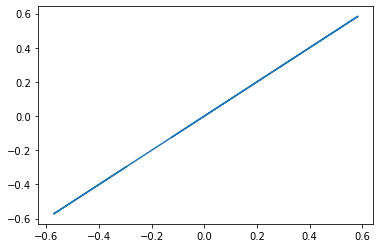

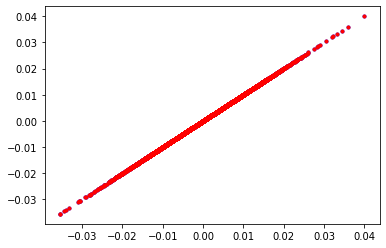

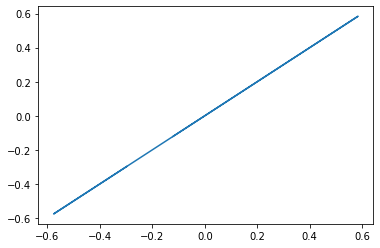

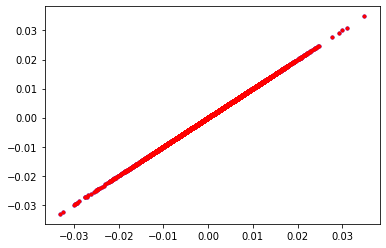

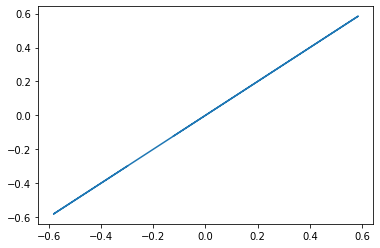

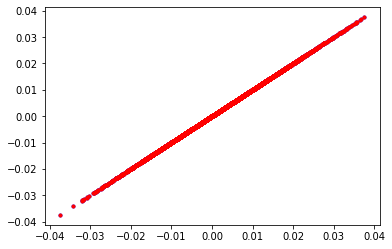

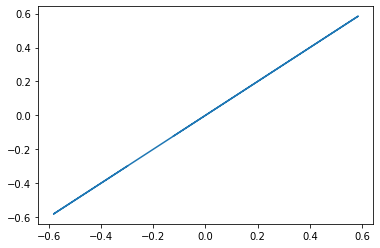

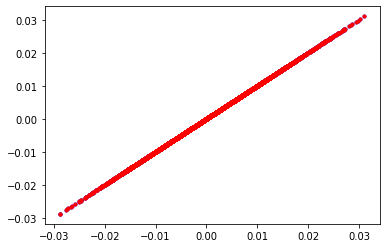

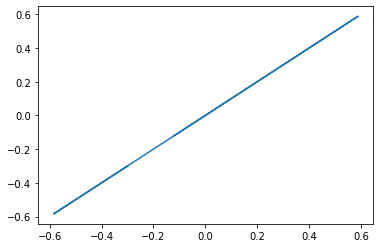

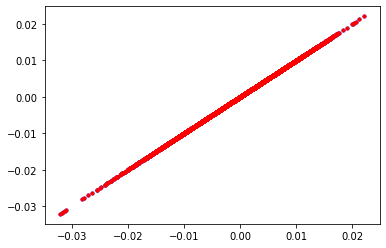

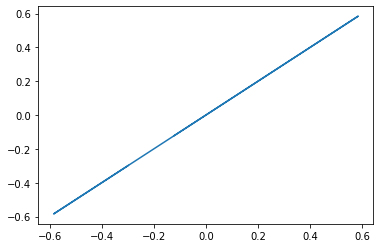

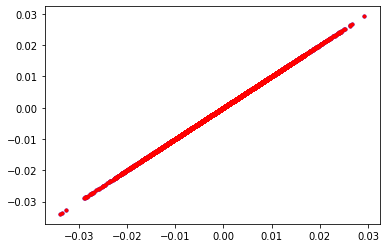

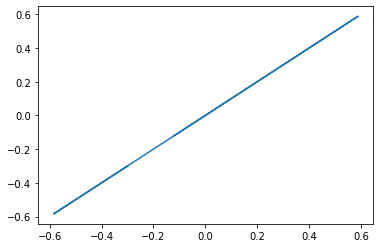

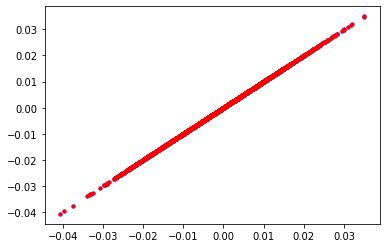

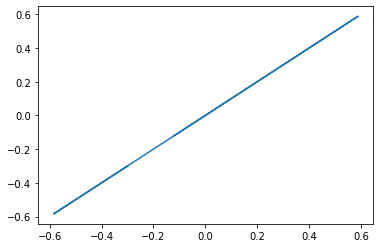

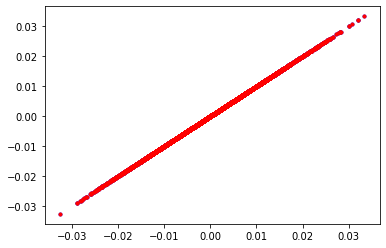

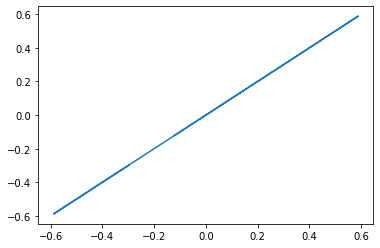

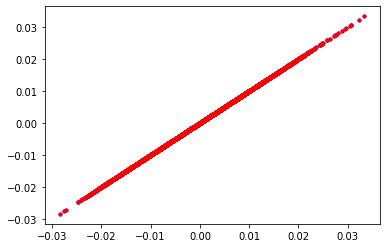

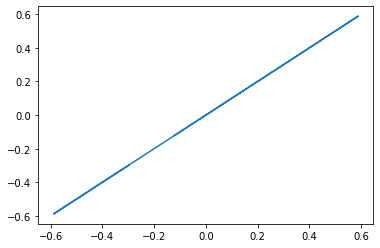

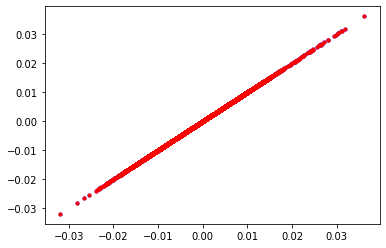

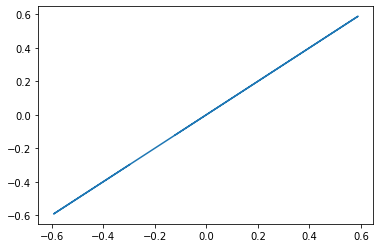

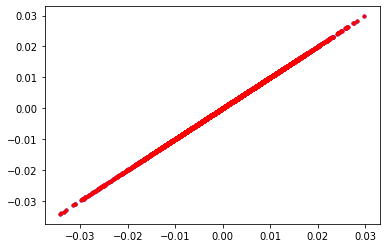

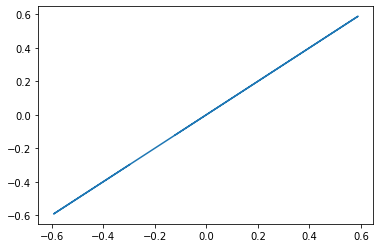

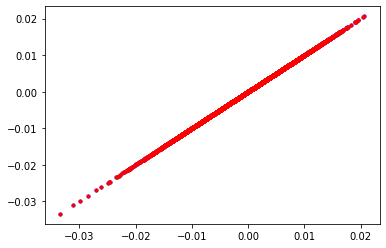

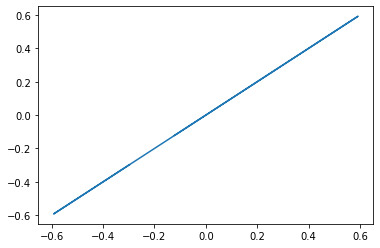

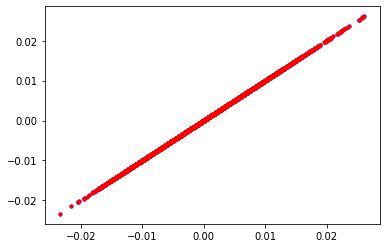

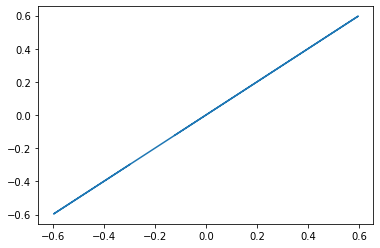

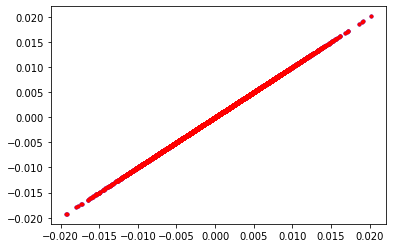

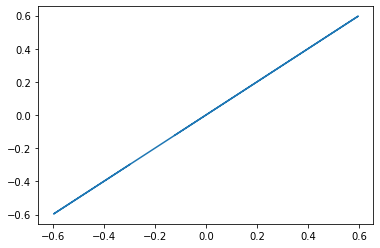

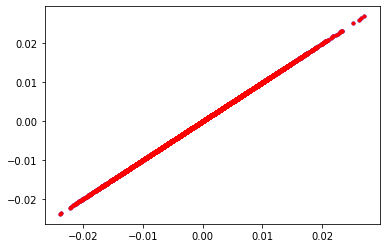

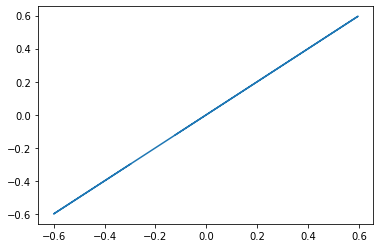

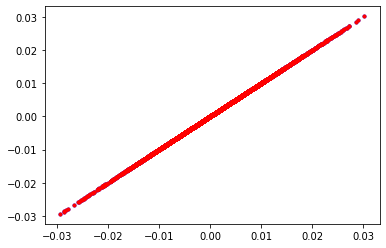

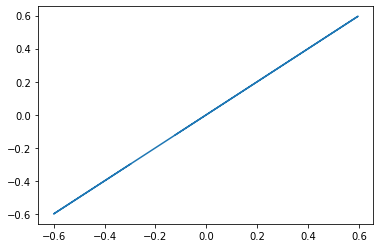

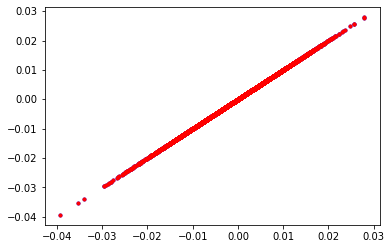

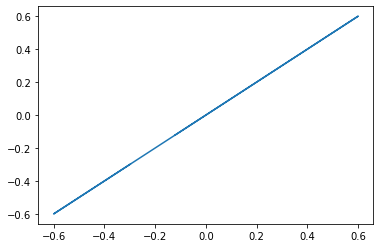

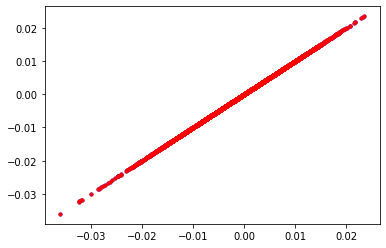

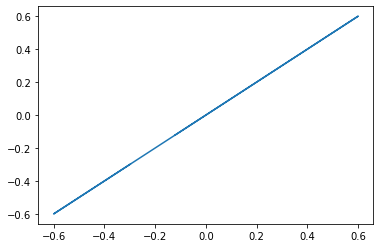

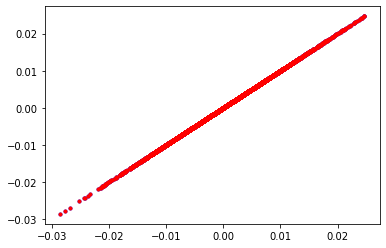

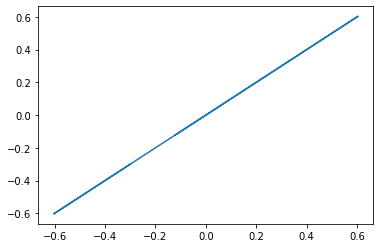

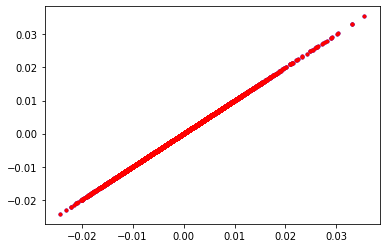

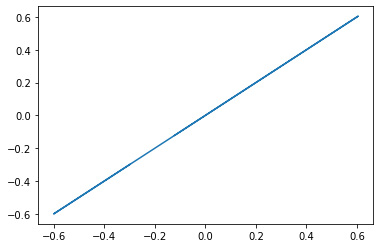

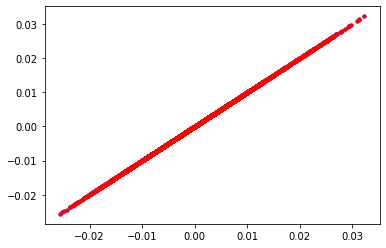

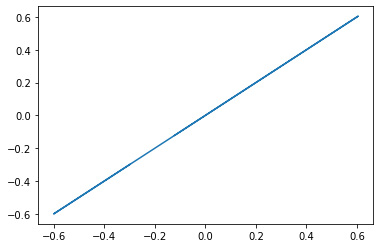

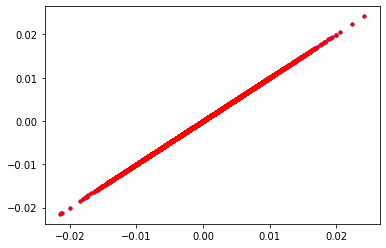

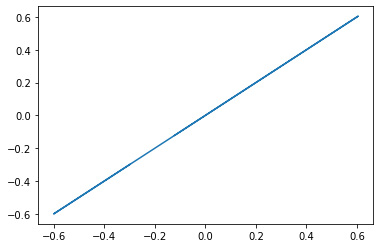

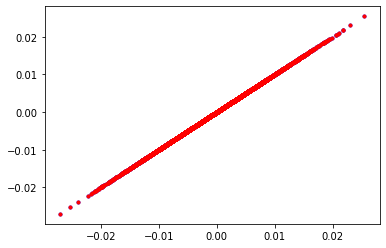

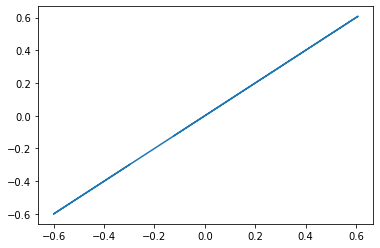

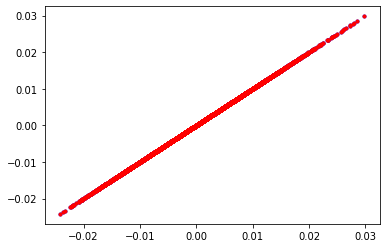

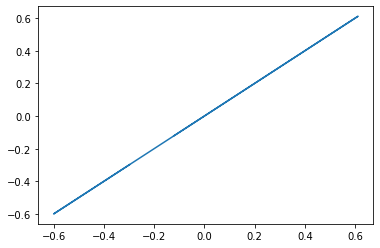

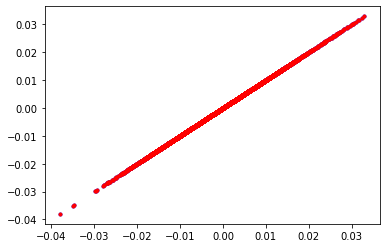

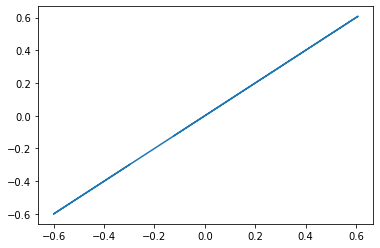

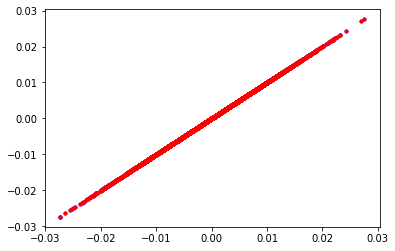

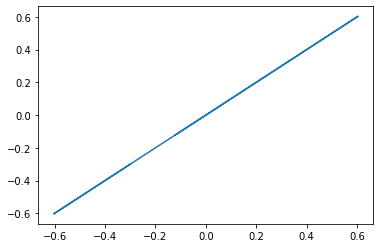

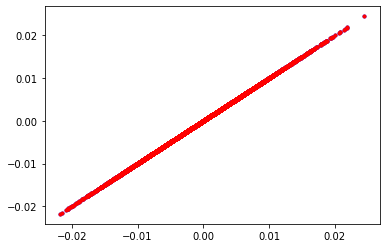

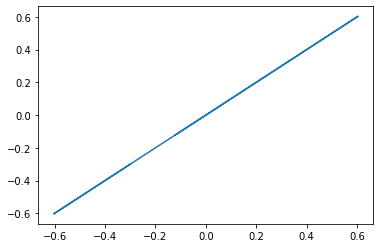

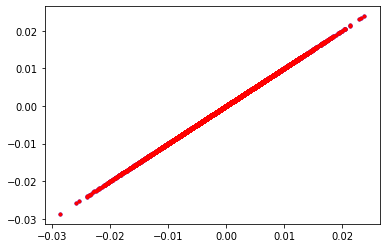

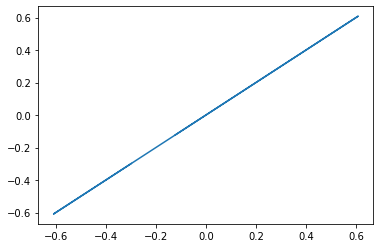

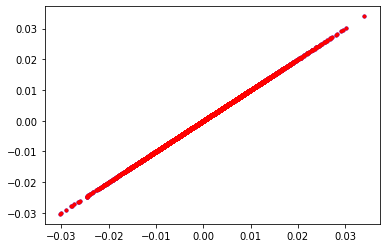

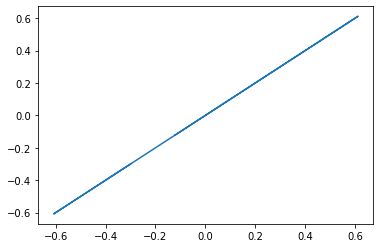

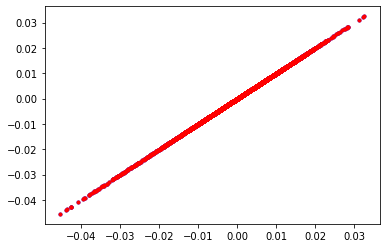

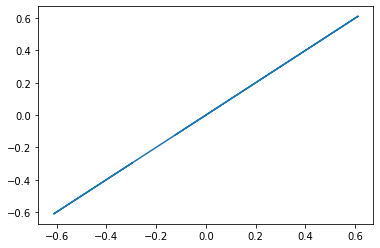

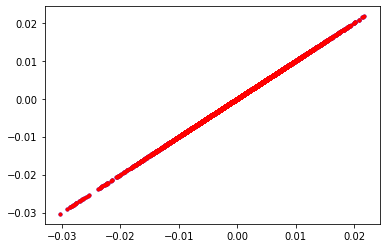

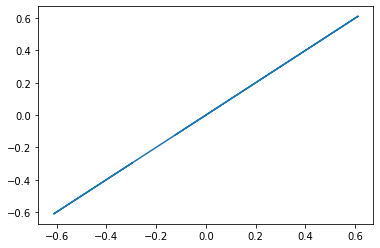

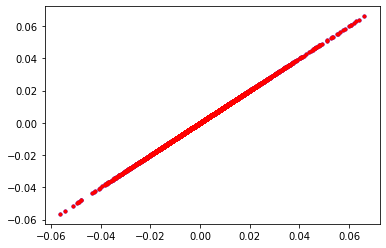

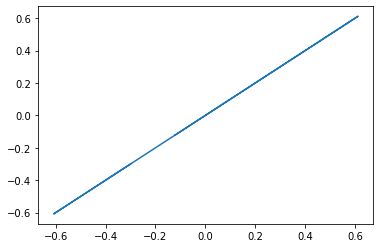

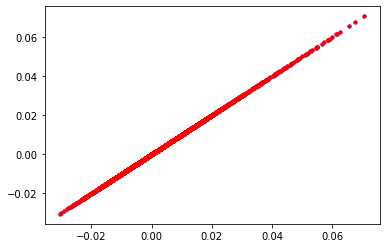

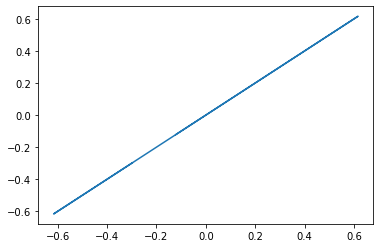

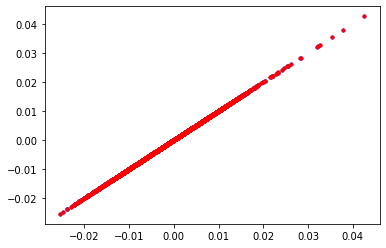

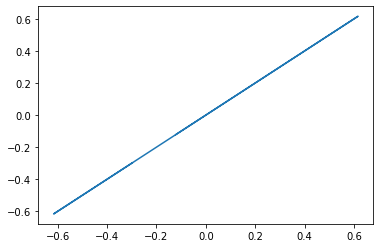

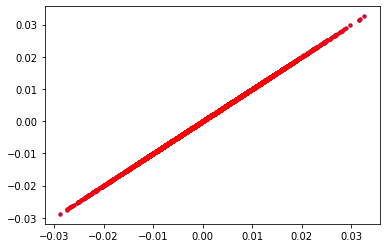

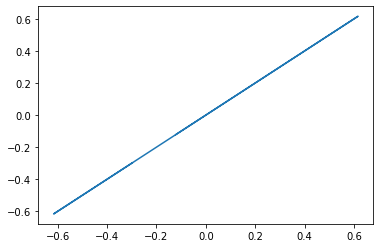

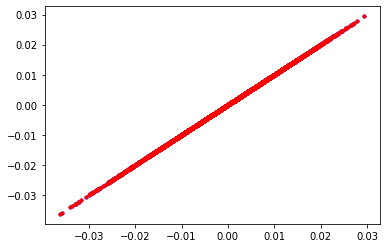

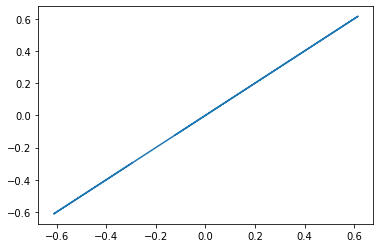

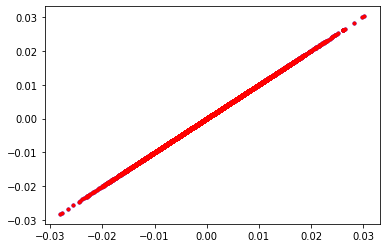

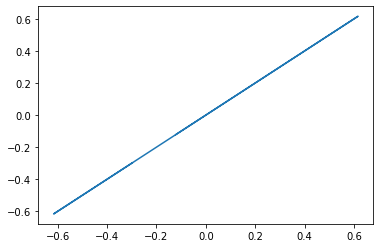

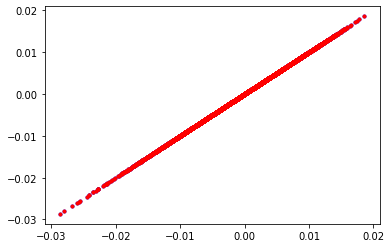

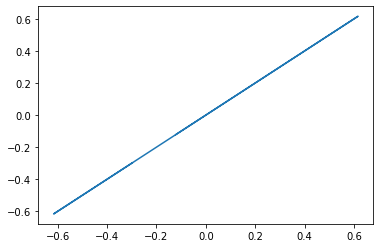

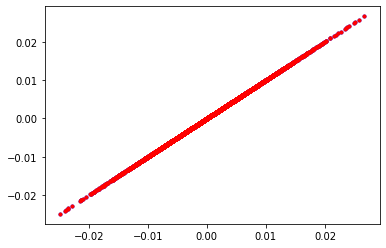

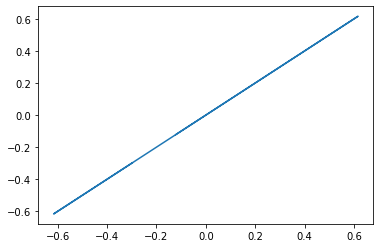

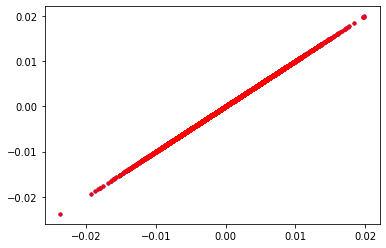

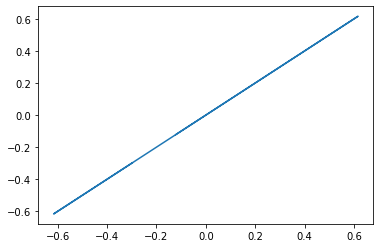

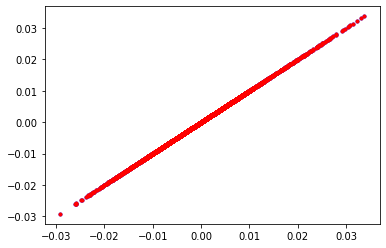

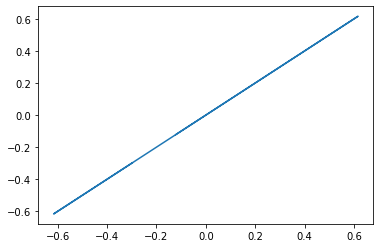

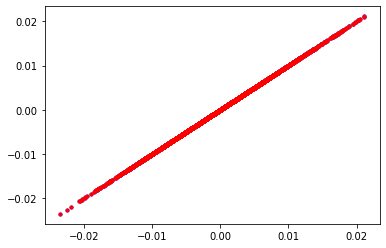

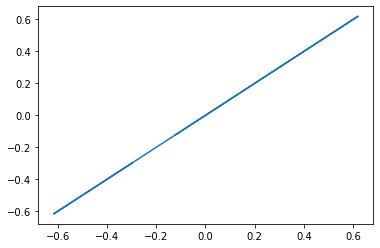

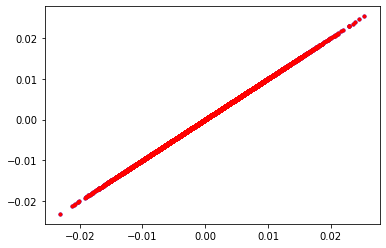

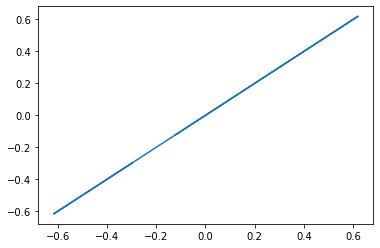

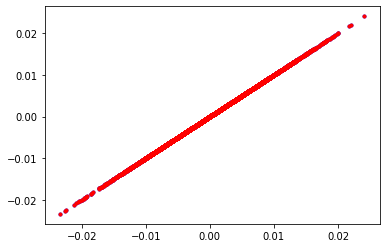

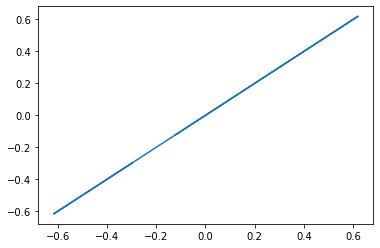

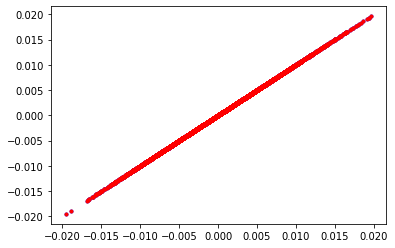

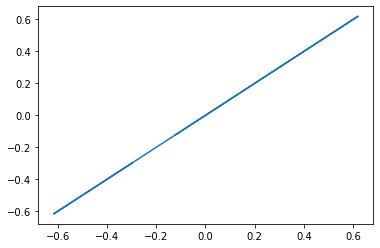

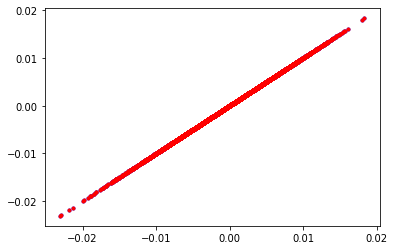

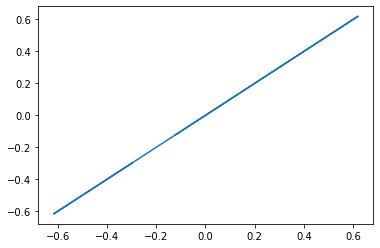

In [21]:
batch_grad_descentBPComp(x_train,y_train, batchsize,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,seed = None, print_op=1)